# Definición de portafolios

Finalmente vamos a determinar portafolios fundamentados del modelo de Swensen y que sean consistentes con el contexto geopolítico y económico actual.

Para simplificar y estar en consonancia con la estrategia pasiva y de largo plazo que estamos proponiendo usaremos ETFs físicos, que representen las regiones en las que el modelo divide la economía global, y agregaremos el Oro y el Bitcoin a la ecuación.

Empresas Estadounidenses.
VOO (Vanguard S&P 500 ETF): ETF que replica el índice S&P 500, compuesto por las 500 empresas más grandes de EE.UU.

Economías emergentes.
VWO (Vanguard FTSE Emerging Markets ETF): ETF que ofrece exposición a acciones de mercados emergentes en diversos sectores.

-Empresas Chinas.
KWEB (KraneShares CSI China Internet ETF): ETF enfocado en empresas chinas de internet y tecnología.
CHIQ (Global X MSCI China Consumer Discretionary ETF): ETF que invierte en empresas chinas del sector consumo discrecional.

-Economías emergentes sin China.
EMXC (iShares MSCI Emerging Markets ex China ETF): ETF que cubre mercados emergentes, excluyendo a China.

-Economías "desarrolladas".
VEA (Vanguard FTSE Developed Markets ETF): ETF que replica acciones de mercados desarrollados (excluyendo EE.UU.).

-Oro
GLD (SPDR Gold Trust): ETF respaldado por oro físico, que sigue el precio del metal precioso.

-Bitcoin
IBIT: (iShares Bitcoin Trust): ETF "físico" de Bitcoin lanzado por BlackRock que permite a los inversores acceder al precio de Bitcoin sin tener que almacenar la criptomoneda directamente.
BTC-USD (Bitcoin vs. Dólar): Dado que IBIT tiene poco tiempo de haber salido al mercado usaremos el índice de Bitcoin.

Las principales incógnitas que pretendemos resolver son las siguientes:

1. ¿Son relevantes todos estos activos?

2. En particular, ¿Tiene sentido separar a las empresas Chinas?

3. ¿Qué tipo de portafolios serían óptimos?

4. ¿Son significativamente diferentes al modelo original propuesto en el modelo de Swensen?

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

[*********************100%***********************]  4 of 4 completed


Rendimiento TOTAL en el periodo ( 1978 días):
 Ticker
CHIQ    0.355706
EMXC    0.274969
KWEB   -0.115915
VWO     0.280896
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
CHIQ    0.057804
EMXC    0.045878
KWEB   -0.022493
VWO     0.046774
dtype: float64



<ipython-input-5-e351203e228a>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_China = df_China.resample('M').last()  # Último precio de cada mes


<Axes: xlabel='Ticker', ylabel='Ticker'>

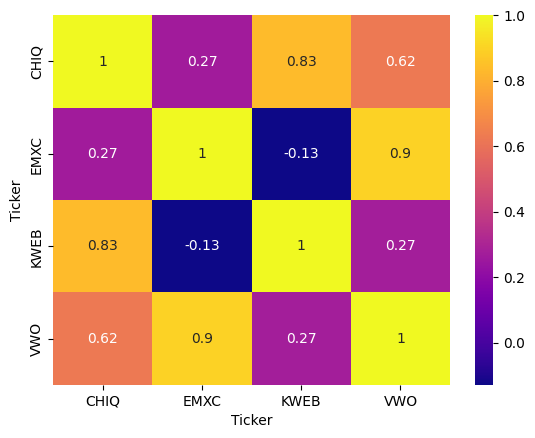

In [ ]:
df_China = yf.download(["VWO",  "KWEB", "CHIQ","EMXC"], "2019-10-01", "2025-03-31")["Close"]
df_China = df_China.resample('M').last()  # Último precio de cada mes
df_China.dropna(axis=0, how="any", inplace=True)
# Calcular rendimiento TOTAL (real) y ANUALIZADO (para comparar con otros periodos)
retorno_total = (df_China.iloc[-1] / df_China.iloc[0]) - 1  # Rendimiento total en el periodo completo

# Anualización (ajusta para periodos de cualquier duración)
dias_totales = (df_China.index[-1] - df_China.index[0]).days
años_transcurridos = dias_totales / 365.25  # 365.25 considera años bisiestos

retorno_anualizado = (1 + retorno_total)**(1/años_transcurridos) - 1  # Fórmula de capitalización compuesta

print("\nRendimiento TOTAL en el periodo (", dias_totales, "días):\n", retorno_total)
print("\nRendimiento ANUALIZADO (equivalente por año):\n", retorno_anualizado)
sns.heatmap(df_China.corr(), annot=True, cmap= 'plasma')

In [ ]:
def generar_pesos(numero, min_val, max_val, decimales=3):
    while True:
        pesos = np.round(np.random.dirichlet(np.ones(numero)), decimales)
        if (min(pesos)>=min_val) & (max(pesos)<=max_val):
            break
    return pesos

In [ ]:
def portafolio_optimo_markowitz_reducido(tickers,
                                  fecha_inicio="2022-01-01",
                                  fecha_fin=None,
                                  diversificacion = "Balanceado",
                                  risk_free_rate = 0.05,
                                  num_portafolios=2000):

    if fecha_fin is None:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')

    if diversificacion == "Libre":
      minimo = 0
      maximo = 1
    else:
      minimo = 0.1
      maximo = 0.6

    # 1. Descarga de datos
    data = yf.download(tickers, start=fecha_inicio, end=fecha_fin, progress=False)["Close"]
    data = data.resample('M').last()  # Último precio de cada mes
    data.dropna(axis=0, how="any", inplace=True)  # Eliminar meses con NaNs (opcional, si hay huecos)
    retornos_mensuales = data.pct_change().dropna()  # Retornos mensuales

    # 3. Cálculo de medias y covarianzas
    #    - media_retornos es el rendimiento promedio diario de cada acción
    #    - covarianza es la matriz de covarianza de los rendimientos diarios
    media_retornos = retornos_mensuales.mean()  # media
    covarianza = retornos_mensuales.cov()       # covarianza

    # 4. Simulación de portafolios aleatorios
    resultados = []
    registro_pesos = []

    #np.random.seed(42)  # Fijar semilla para reproducibilidad (opcional)

    for _ in range(num_portafolios):
        # Generar pesos aleatorios que sumen 1
        while True:
          pesos = generar_pesos(len(tickers),minimo,maximo)
          r_pesos = pesos.tolist()
          if r_pesos in registro_pesos:
            continue
          else:
            break

        # Rendimiento esperado del portafolio (anualizado)
        rendimiento_esperado = np.sum(media_retornos * pesos) * 12  # 12 meses
        var_portafolio = np.dot(pesos.T, np.dot(covarianza * 12, pesos))  # Anualizar covarianza
        volatilidad = np.sqrt(var_portafolio)

        resultados.append([volatilidad, rendimiento_esperado])
        registro_pesos.append(r_pesos)

    # Convertir resultados a DataFrame
    df_pesos = pd.DataFrame(registro_pesos, columns=tickers)
    resultados = np.array(resultados)
    df_resultados = pd.DataFrame({
        'Volatilidad': resultados[:, 0],
        'Rendimiento': resultados[:, 1]
    })
    df_completo = df_resultados.join(df_pesos)
    # Hallar el portafolio con mejor razón de Sharpe (asumiendo risk-free=0)
    df_resultados['Sharpe'] = (df_resultados['Rendimiento']-risk_free_rate) / df_resultados['Volatilidad']
    max_sharpe_idx = df_resultados['Sharpe'].idxmax()

    # Pesos portafolio optimo
    return df_completo.loc[max_sharpe_idx]

In [ ]:
portafolio_optimo_markowitz_reducido(["VWO",  "CHIQ","EMXC"],fecha_inicio = "2019-10-01",fecha_fin="2025-03-31", diversificacion= "Libre")

<ipython-input-9-7ded170cffc2>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes


,1572
Volatilidad,0.354198
Rendimiento,0.116728
VWO,0.960000
CHIQ,0.033000
EMXC,0.007000


In [ ]:
portafolios = []

for i in range(50):
  portafolio_optimo = portafolio_optimo_markowitz_reducido(["VWO",  "CHIQ","EMXC"],fecha_inicio = "2019-10-01",fecha_fin="2025-03-31", diversificacion= "Libre")
  portafolios.append(portafolio_optimo)
df_portafolios_China=pd.DataFrame(portafolios)

<ipython-input-21-597df66d4bc8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes
<ipython-input-21-597df66d4bc8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes
<ipython-input-21-597df66d4bc8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes
<ipython-input-21-597df66d4bc8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes
<ipython-input-21-597df66d4bc8>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes
<ipyt

In [ ]:
#df_portafolios_China
df_portafolios_China.describe()

,Volatilidad,Rendimiento,VWO,CHIQ,EMXC
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.355684,0.117076,0.965700,0.031600,0.003000
std,0.006538,0.001260,0.022754,0.023098,0.002312
min,0.334341,0.112935,0.891000,0.002000,0.000000
25%,0.353351,0.116650,0.958000,0.016000,0.001000
50%,0.356851,0.117303,0.970000,0.025000,0.002000
75%,0.360550,0.117999,0.982750,0.039750,0.004750
max,0.364597,0.118792,0.997000,0.107000,0.009000


## Observaciones

En primer lugar observamos que la desviación estandar es baja para todos los activos, esto da testimonio de que la función realmente esta dando portafolios óptimos dentro de todas las posibilidades. Adicionalmente se realizaron distintas pruebas similares con otros activos y distintas magnitudes en el número de portafolios y en todas la desviación estandar mostró que bastante cercanía entre los portafolios óptimos

En segundo lugar, luego de correr 50 veces 2,000 portafolios, y dada la matriz de correlación, concluimos que los ETFs "CHIQ" Y "EMXC" no son significativos por lo que no serán considerados dentro del portafolio general. Esta conclusión se basa en lo siguiente.

-"CHIQ":
1. El máximo de los valores tienen un porcentaje de 1.8% y la media es de .54%, valores no significativos.
2. Además la matriz de correlaciones muestra que la correlación entre "CHIQ" y "KWEB" es de .83.

-"EMXC"
1. Tiene un porcentaje medio de 2.3% y el 75% de los portafolios tiene un porcentaje menor o igual al 4%. Si bien al menos un portafolio asigna el 7.8% en suma no parece que este activo aporte algo significativo.
2. La correlación entre "VWO" y "EMXC" es de .9.
3. Adicionalmente el ETF "EMXC" es relativamente reciente por lo que al incluirlo solo podemos considerar datos dentro dentro de los últimos 6 años.   

# Definición portafolios
A continuación comenzaremos a definir portafolios siguiendo los siguientes criterios:

## 0. Últimos 10 años.

## I. Elección de activos:
1. Tradicional: Considerando únicamente las tres regiones EU, Países "desarrollados" y países "en vías de desarrollo".
2. Actual: Tradicional + KWEB+ Oro + Bitcoin.

## II. Diversificación:
1. Balanceada: Porcentajes entre 10% y 75%*
2. Libre: Sin restricción en los porcentajes

## III. Rendimiento VS Riesgo
1. Óptimo: Portafolio óptimo.
2. Concervador: 1-3 portafolios significativamente menos riesgosos (en caso de que existan).
3. Mayor rendimiento: 1-3 portafolios significativamente de mayor rendimiento (en caso de que existan).

## Nota:
1. Los portafolios se obtendrán ajustando los distintos valores, a partir de los valores del portafolio óptimo, de manera manual.
2. En caso de que haya muchos portafolios sin cambios significativos, se usaran las características secundarias para filstrar (En caso de que haya varios portafolios con diversificación Libre que sean concervadores- sin diferencia significativa en la volatilidad y el sharpe ratio se usarán el rendimiento como primer criterio de desempate y finalmente se elegiran los portafolios más balanceados como último criterio)

${\bf \text{*:Recordar que el portafolio completo incluye otros activos como bonos, bienes raíces, etc. por lo que los porcentajes reales dentro del portafolio completo podrían reducirse hasta la mitad}}$

In [ ]:
def portafolio_optimo_markowitz(tickers,
                                  fecha_inicio="2022-01-01",
                                  fecha_fin=None,
                                  diversificacion = "Balanceado",
                                  risk_free_rate = 0.05,
                                  num_portafolios=25000):
    """
    Dada una lista de 'tickers', descarga sus precios desde 'fecha_inicio'
    hasta 'fecha_fin' (por defecto, la fecha actual si es None).
    Calcula y grafica la frontera eficiente (portafolio de Markowitz)
    usando un muestreo aleatorio de pesos.
    """
    if fecha_fin is None:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')

    if diversificacion == "Libre":
      minimo = 0
      maximo = 1
    else:
      minimo = 0.1
      maximo = 0.6

    # 1. Descarga de datos
    data = yf.download(tickers, start=fecha_inicio, end=fecha_fin, progress=False)["Close"]
    data = data.resample('M').last()  # Último precio de cada mes
    data.dropna(axis=0, how="any", inplace=True)  # Eliminar meses con NaNs (opcional, si hay huecos)
    retornos_mensuales = data.pct_change().dropna()  # Retornos mensuales

    # Calcular rendimiento TOTAL (real) y ANUALIZADO (para comparar con otros periodos)
    retorno_total = (data.iloc[-1] / data.iloc[0]) - 1  # Rendimiento total en el periodo completo

    # Anualización (ajusta para periodos de cualquier duración)
    dias_totales = (data.index[-1] - data.index[0]).days
    años_transcurridos = dias_totales / 365.25  # 365.25 considera años bisiestos
    retorno_anualizado = (1 + retorno_total)**(1/años_transcurridos) - 1  # Fórmula de capitalización compuesta
    print("\nRendimiento TOTAL en el periodo (", dias_totales, "días):\n", retorno_total)
    print("\nRendimiento ANUALIZADO (equivalente por año):\n", retorno_anualizado)

    # 3. Cálculo de medias y covarianzas
    #    - media_retornos es el rendimiento promedio diario de cada acción
    #    - covarianza es la matriz de covarianza de los rendimientos diarios
    media_retornos = retornos_mensuales.mean()  # media
    covarianza = retornos_mensuales.cov()       # covarianza

    # 4. Simulación de portafolios aleatorios
    resultados = []
    registro_pesos = []

   # np.random.seed(42)  # Fijar semilla para reproducibilidad (opcional)

    for _ in range(num_portafolios):
        # Generar pesos aleatorios que sumen 1
        while True:
          pesos = generar_pesos(len(tickers),minimo,maximo)
          r_pesos = pesos.tolist()
          if r_pesos in registro_pesos:
            continue
          else:
            break
        # Rendimiento esperado del portafolio (anualizado)
        rendimiento_esperado = np.sum(media_retornos * pesos) * 12  # 12 meses
        var_portafolio = np.dot(pesos.T, np.dot(covarianza * 12, pesos))  # Anualizar covarianza
        volatilidad = np.sqrt(var_portafolio)

        resultados.append([rendimiento_esperado, volatilidad])
        registro_pesos.append(r_pesos)

    # Convertir resultados a DataFrame
    resultados = np.array(resultados)
    df_resultados = pd.DataFrame({
        'Rendimiento': resultados[:, 0],
        'Volatilidad': resultados[:, 1]

    })
    df_pesos = pd.DataFrame(registro_pesos, columns=tickers)

    # Hallar el portafolio con mejor razón de Sharpe (asumiendo risk-free=0)
    df_resultados['Sharpe'] = (df_resultados['Rendimiento']-risk_free_rate) / df_resultados['Volatilidad']
    max_sharpe_idx = df_resultados['Sharpe'].idxmax()
    mejor_sharpe = df_resultados.loc[max_sharpe_idx]
    df_resultados = df_resultados.join(df_pesos)

#####################################################################################

    # 6. Graficar también riesgo y rendimiento de cada acción individual
    #    Aseguramos la correspondencia de índices con el orden en 'tickers'.
    #rendimiento_acciones = media_retornos * 12  # Anualización mensual (12 meses)
    volatilidad_acciones = retornos_mensuales.std() * np.sqrt(12)  # Anualización mensual
    # Reindexar al orden de 'tickers' para evitar desalineaciones
    #rendimiento_acciones = rendimiento_acciones.reindex(tickers)
    volatilidad_acciones = volatilidad_acciones.reindex(tickers)

    #print("Rendimientos anuales (acciones):\n", rendimiento_acciones)
    print("Volatilidades anuales (acciones):\n", volatilidad_acciones)

    plt.figure(figsize=(10, 6))
    plt.scatter(volatilidad_acciones, retorno_anualizado,
                color='blue', label='Acciones')

    # Anotar cada acción en su posición correspondiente
    for ticker in tickers:
        plt.annotate(ticker,
                     (volatilidad_acciones[ticker],
                      retorno_anualizado[ticker]))

    plt.xlabel('Volatilidad (Riesgo)')
    plt.ylabel('Rendimiento Anual (%)')
    plt.title('Rendimiento vs Riesgo de Acciones Individuales')
    plt.legend()
    plt.show()
########
    print("Mapa de correlación")
    sns.heatmap(data.corr(), annot=True, cmap= 'plasma')

########
    # 5. Gráfica de la frontera eficiente
    plt.figure(figsize=(10, 6))
    plt.scatter(df_resultados['Volatilidad'],
                df_resultados['Rendimiento'],
                c=df_resultados['Sharpe'], cmap='viridis', alpha=0.6)
    plt.colorbar(label='Ratio de Sharpe')
    plt.scatter(mejor_sharpe['Volatilidad'],
                mejor_sharpe['Rendimiento'],
                color='r', marker='*', s=300, label='Mejor Sharpe')
    plt.xlabel('Volatilidad (Riesgo)')
    plt.ylabel('Rendimiento Anual (%)')
    plt.title('Frontera Eficiente - Portafolio de Markowitz')
    plt.legend()
    plt.show()

    # Retorno de resultados
    return {
        "portafolio_mejor_sharpe": {
            "rendimiento": mejor_sharpe['Rendimiento'],
            "volatilidad": mejor_sharpe['Volatilidad'],
            "sharpe_ratio": mejor_sharpe['Sharpe'],
            "pesos": {t: round(w, 4) for t, w in zip(tickers, registro_pesos[max_sharpe_idx])}
        }, "df_portafolios": df_resultados
    }

## Portafolio distribucion original Swensen 2007-2017
Ahora analizaremos el rendimiento de la distribución original de Swensen entre los años 2007-2017.

Es importante aclarar que el modelo original da una distribución regional y no especifica activos específicos. Sin embargo remarcamos que la propuesta es dar una estrategia pasiva, segura, sencilla y a largo plazo, para usuarios particulares, que si bien podría recibir ajustes a lo largo de los años, en principio estpa excenta de realizar movimientos como: vender activos para comprar otros. Por esta razón consideramos que los activos que más se ajustan a todas estas condiciones son los previamente seleccionados.

Nota: En este caso se usa SPY en lugar de VOO ya que este último fue creado en 2010.

<ipython-input-32-984719cf44c3>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes



Rendimiento TOTAL en el periodo ( 3622 días):
 Ticker
SPY    1.061924
VEA    0.205208
VWO    0.184133
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
SPY    0.075702
VEA    0.019001
VWO    0.017189
dtype: float64
Volatilidades anuales (acciones):
 Ticker
SPY    0.152021
VWO    0.239137
VEA    0.192688
dtype: float64


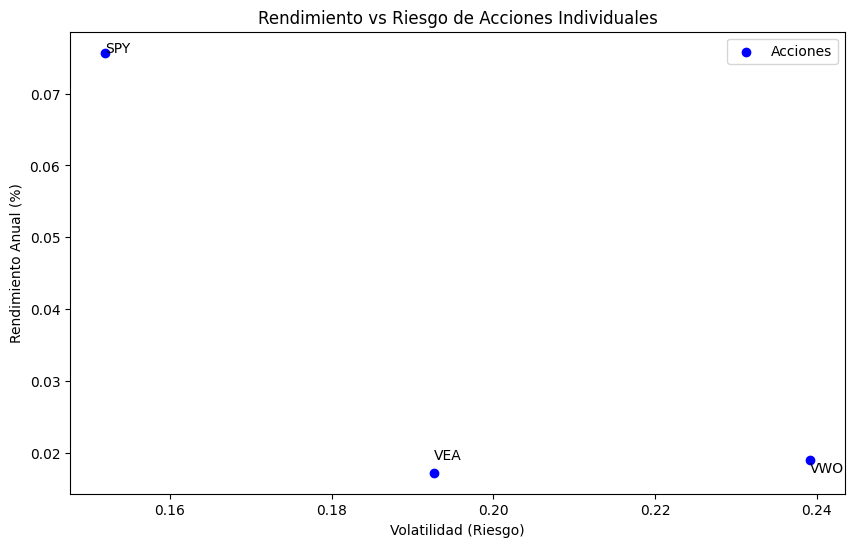

Mapa de correlación


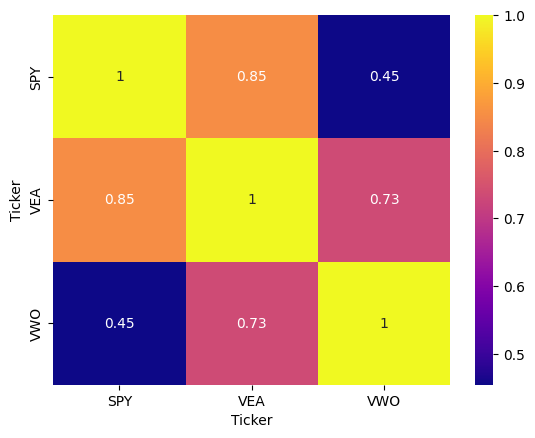

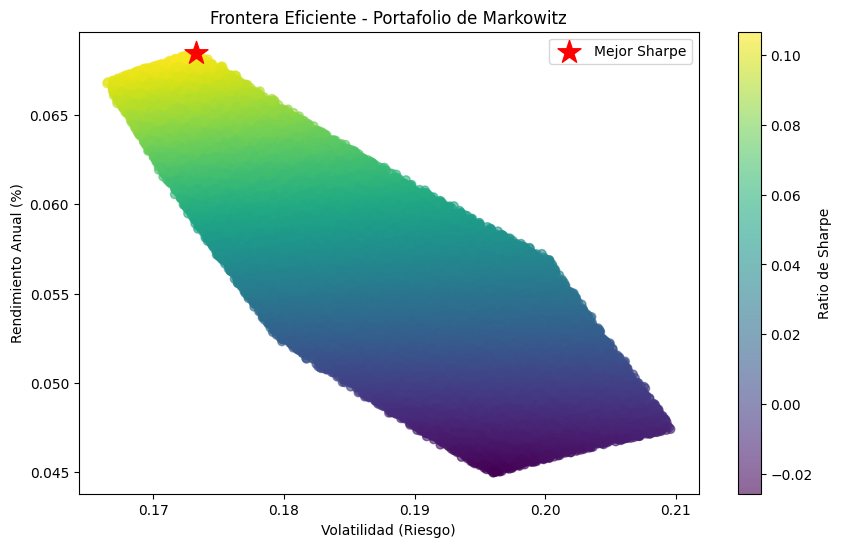

Portafolios Swensen


,Volatilidad,Rendimiento,SPY,VWO,VEA
count,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.173938,0.068041,0.589351,0.105432,0.305108
std,0.000669,0.000348,0.008725,0.002662,0.008369
min,0.172980,0.067257,0.570000,0.101000,0.291000
25%,0.173370,0.067840,0.584000,0.104000,0.299000
50%,0.173925,0.068028,0.590000,0.105000,0.304000
75%,0.174441,0.068360,0.597000,0.108000,0.311000
max,0.175310,0.068488,0.600000,0.110000,0.320000


In [ ]:
Prtf_Trad_10_Bal = portafolio_optimo_markowitz(["SPY", "VWO", "VEA"],fecha_inicio = "2007-08-01",fecha_fin="2017-07-31")
print("Portafolios Swensen")
PSwensen_10 = Prtf_Trad_10_Bal["df_portafolios"][(Prtf_Trad_10_Bal["df_portafolios"]["SPY"]<=.68) & (Prtf_Trad_10_Bal["df_portafolios"]["VWO"]<=.11)& (Prtf_Trad_10_Bal["df_portafolios"]["VEA"]<=.32)]
PSwensen_10.describe()

## Portafolios Tradicionales
Balanceados

In [ ]:
def portafolio_optimo_markowitz(tickers,
                                  fecha_inicio="2022-01-01",
                                  fecha_fin=None,
                                  diversificacion = "Balanceado",
                                  risk_free_rate = 0.05,
                                  num_portafolios=10000):
    """
    Dada una lista de 'tickers', descarga sus precios desde 'fecha_inicio'
    hasta 'fecha_fin' (por defecto, la fecha actual si es None).
    Calcula y grafica la frontera eficiente (portafolio de Markowitz)
    usando un muestreo aleatorio de pesos.
    """
    if fecha_fin is None:
        fecha_fin = datetime.now().strftime('%Y-%m-%d')

    if diversificacion == "Libre":
      minimo = 0
      maximo = 1
    else:
      minimo = 0.1
      maximo = 0.6

    # 1. Descarga de datos
    data = yf.download(tickers, start=fecha_inicio, end=fecha_fin, progress=False)["Close"]
    data = data[tickers]  # <--- Orden explícito aquí
    data = data.resample('M').last().dropna()
    retornos_mensuales = data.pct_change().dropna()  #

 #   data = data.resample('M').last()  # Último precio de cada mes
 #   data.dropna(axis=0, how="any", inplace=True)  # Eliminar meses con NaNs (opcional, si hay huecos)
 #   retornos_mensuales = data.pct_change().dropna()  # Retornos mensuales

    # Calcular rendimiento TOTAL (real) y ANUALIZADO (para comparar con otros periodos)
    #retorno_total = (data.iloc[-1] / data.iloc[0]) - 1  # Rendimiento total en el periodo completo

    # Anualización (ajusta para periodos de cualquier duración)
    #dias_totales = (data.index[-1] - data.index[0]).days
    #años_transcurridos = dias_totales / 365.25  # 365.25 considera años bisiestos
    #retorno_anualizado = (1 + retorno_total)**(1/años_transcurridos) - 1  # Fórmula de capitalización compuesta
    # Precios promedio
    precio_inicial = data.iloc[:3].mean()
    precio_final = data.iloc[-3:].mean()

    # Ajuste de período (evitando sesgo por promedios)
    fecha_inicio = data.index[2]    # Tercer dato del promedio inicial
    fecha_fin = data.index[-3]      # Tercer dato del promedio final
    dias = (fecha_fin - fecha_inicio).days
    años_ajustados = dias / 365.25

    # Retorno anualizado
    retorno_total = (precio_final / precio_inicial) - 1
    retorno_anualizado = (1 + retorno_total)**(1/años_ajustados) - 1

    print("\nRendimiento TOTAL en el periodo (", dias_totales, "días):\n", retorno_total)
    print("\nRendimiento ANUALIZADO (equivalente por año):\n", retorno_anualizado)

    # 3. Cálculo de medias y covarianzas
    #    - media_retornos es el rendimiento promedio diario de cada acción
    #    - covarianza es la matriz de covarianza de los rendimientos diarios
    media_retornos = retornos_mensuales.mean()  # media
    covarianza = retornos_mensuales.cov()       # covarianza

    # 4. Simulación de portafolios aleatorios
    resultados = []
    registro_pesos = []

   # np.random.seed(42)  # Fijar semilla para reproducibilidad (opcional)

    for _ in range(num_portafolios):
        # Generar pesos aleatorios que sumen 1
        while True:
          pesos = generar_pesos(len(tickers),minimo,maximo)
          r_pesos = pesos.tolist()
          if r_pesos in registro_pesos:
            continue
          else:
            break
        # Rendimiento esperado del portafolio (anualizado)
        rendimiento_esperado = np.sum(retorno_anualizado * pesos)
        var_portafolio = np.dot(pesos.T, np.dot(covarianza * 12, pesos))  # Anualizar covarianza
        volatilidad = np.sqrt(var_portafolio)

        resultados.append([rendimiento_esperado, volatilidad])
        registro_pesos.append(r_pesos)

    # Convertir resultados a DataFrame
    resultados = np.array(resultados)
    df_resultados = pd.DataFrame({
        'Rendimiento': resultados[:, 0],
        'Volatilidad': resultados[:, 1]

    })
    df_pesos = pd.DataFrame(registro_pesos, columns=tickers)

    # Hallar el portafolio con mejor razón de Sharpe (asumiendo risk-free=0)
    df_resultados['Sharpe'] = (df_resultados['Rendimiento']-risk_free_rate) / df_resultados['Volatilidad']
    max_sharpe_idx = df_resultados['Sharpe'].idxmax()
    mejor_sharpe = df_resultados.loc[max_sharpe_idx]
    df_resultados = df_resultados.join(df_pesos)

#####################################################################################

    # 6. Graficar también riesgo y rendimiento de cada acción individual
    #    Aseguramos la correspondencia de índices con el orden en 'tickers'.
    #rendimiento_acciones = media_retornos * 12  # Anualización mensual (12 meses)
    volatilidad_acciones = retornos_mensuales.std() * np.sqrt(12)  # Anualización mensual
    # Reindexar al orden de 'tickers' para evitar desalineaciones
    #rendimiento_acciones = rendimiento_acciones.reindex(tickers)
#    volatilidad_acciones = volatilidad_acciones.reindex(tickers)

    #print("Rendimientos anuales (acciones):\n", rendimiento_acciones)
    print("Volatilidades anuales (acciones):\n", volatilidad_acciones)

#    plt.figure(figsize=(10, 6))
#    plt.scatter(volatilidad_acciones, retorno_anualizado,
#                color='blue', label='Acciones')

    # Anotar cada acción en su posición correspondiente
#    for ticker in tickers:
#        plt.annotate(ticker,
#                     (volatilidad_acciones[ticker],
#                      retorno_anualizado[ticker]))

#    plt.xlabel('Volatilidad (Riesgo)')
#    plt.ylabel('Rendimiento Anual (%)')
#    plt.title('Rendimiento vs Riesgo de Acciones Individuales')
#    plt.legend()
#    plt.show()
########
#    print("Mapa de correlación")
#    sns.heatmap(data.corr(), annot=True, cmap= 'plasma')

########
    # 5. Gráfica de la frontera eficiente
#    plt.figure(figsize=(10, 6))
#    plt.scatter(df_resultados['Volatilidad'],
#                df_resultados['Rendimiento'],
#                c=df_resultados['Sharpe'], cmap='viridis', alpha=0.6)
#    plt.colorbar(label='Ratio de Sharpe')
#    plt.scatter(mejor_sharpe['Volatilidad'],
#                mejor_sharpe['Rendimiento'],
#                color='r', marker='*', s=300, label='Mejor Sharpe')
#    plt.xlabel('Volatilidad (Riesgo)')
#    plt.ylabel('Rendimiento Anual (%)')
#    plt.title('Frontera Eficiente - Portafolio de Markowitz')
#    plt.legend()
#    plt.show()

    # Retorno de resultados
    return {
        "portafolio_mejor_sharpe": {
            "rendimiento": mejor_sharpe['Rendimiento'],
            "volatilidad": mejor_sharpe['Volatilidad'],
            "sharpe_ratio": mejor_sharpe['Sharpe'],
            "pesos": {t: round(w, 4) for t, w in zip(tickers, registro_pesos[max_sharpe_idx])}
        }, "df_portafolios": df_resultados
    }

In [ ]:
Prtf_Act_Lib = portafolio_optimo_markowitz(["VOO", "VWO","CHIQ", "VEA","GLD","BTC-USD"],fecha_inicio = "2015-04-01",fecha_fin="2025-03-31", diversificacion = "Libre")
print("------------------------------------")
print("PORTAFOLIO ÓPTIMO")
Prtf_Act_Lib["portafolio_mejor_sharpe"]

<ipython-input-90-756aa0df9547>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last().dropna()



Rendimiento TOTAL en el periodo ( 1978 días):
 Ticker
VOO          2.338127
VWO          0.413303
CHIQ         0.636349
VEA          0.668767
GLD          1.370683
BTC-USD    367.947043
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
VOO        0.133925
VWO        0.036728
CHIQ       0.052690
VEA        0.054845
GLD        0.094176
BTC-USD    0.852045
dtype: float64
Volatilidades anuales (acciones):
 Ticker
VOO        0.154531
VWO        0.163416
CHIQ       0.311690
VEA        0.155251
GLD        0.140575
BTC-USD    0.746478
dtype: float64
------------------------------------
PORTAFOLIO ÓPTIMO


{'rendimiento': np.float64(0.4155512597841878),
 'volatilidad': np.float64(0.3314395209679653),
 'sharpe_ratio': np.float64(1.1029199496686442),
 'pesos': {'VOO': 0.317,
  'VWO': 0.002,
  'CHIQ': 0.003,
  'VEA': 0.005,
  'GLD': 0.265,
  'BTC-USD': 0.408}}

<ipython-input-32-984719cf44c3>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes



Rendimiento TOTAL en el periodo ( 3623 días):
 Ticker
VEA    0.673105
VOO    2.189461
VWO    0.384318
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
VEA    0.053257
VOO    0.124040
VWO    0.033329
dtype: float64
Volatilidades anuales (acciones):
 Ticker
VOO    0.154531
VWO    0.163416
VEA    0.155251
dtype: float64


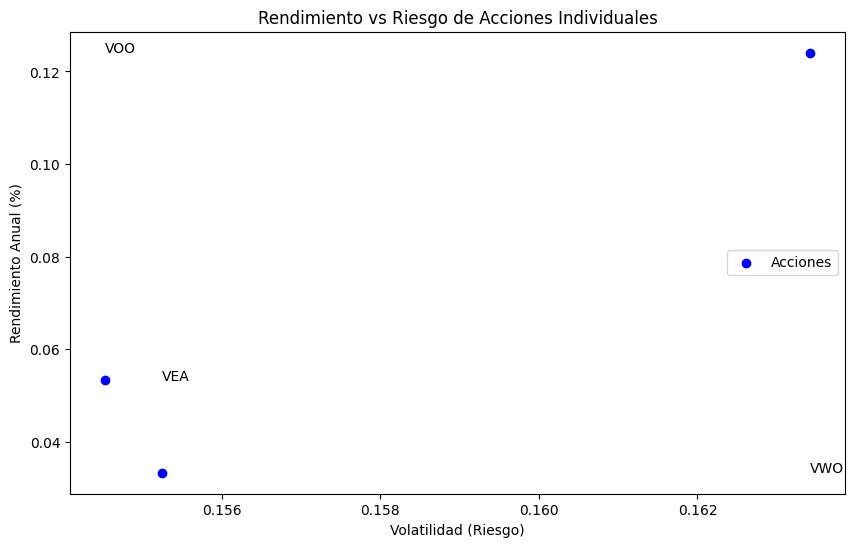

Mapa de correlación


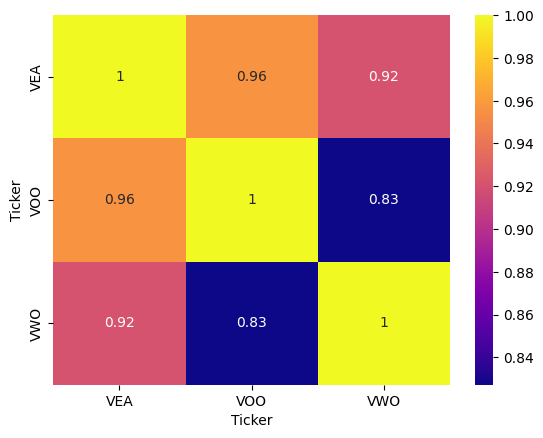

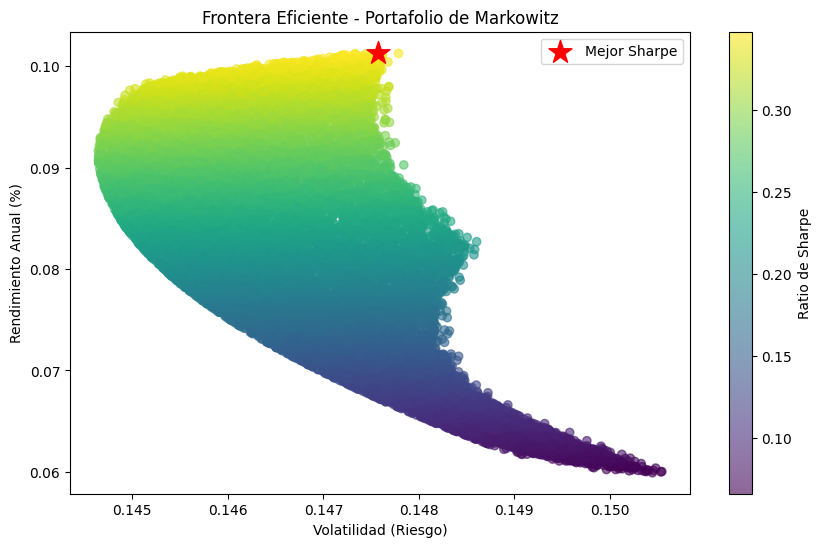

------------------------------------
PORTAFOLIO ÓPTIMO


{'volatilidad': np.float64(0.14757283296295132),
 'rendimiento': np.float64(0.10132678675425871),
 'sharpe_ratio': np.float64(0.3478064744284233),
 'pesos': {'VOO': 0.297, 'VWO': 0.599, 'VEA': 0.104}}

In [ ]:
Prtf_Trad_10_Bal = portafolio_optimo_markowitz(["VOO", "VWO", "VEA"],fecha_inicio = "2015-04-01",fecha_fin="2025-03-31")
print("------------------------------------")
print("PORTAFOLIO ÓPTIMO")
Prtf_Trad_10_Bal["portafolio_mejor_sharpe"]

In [ ]:
print("Portafolios Concervadores")
Prtf_Trad_10_Bal["df_portafolios"][(Prtf_Trad_10_Bal["df_portafolios"]["VOO"]<=.25) & (Prtf_Trad_10_Bal["df_portafolios"]["VWO"]<=.51)& (Prtf_Trad_10_Bal["df_portafolios"]["VEA"]<=.25)]

Portafolios Concervadores


,Volatilidad,Rendimiento,VOO,VWO,VEA
96,0.145476,0.092906,0.250,0.508,0.242
8467,0.145428,0.092882,0.244,0.509,0.247
9476,0.145438,0.092834,0.246,0.508,0.246
13516,0.145422,0.092602,0.247,0.505,0.248
19272,0.145309,0.092806,0.247,0.508,0.244
20585,0.145329,0.092777,0.250,0.507,0.242
22959,0.145261,0.092847,0.240,0.510,0.249
23486,0.145408,0.092305,0.249,0.501,0.250


${\bf \text{*:La gráfica nos muestra que no hay portafolios con un mayor rendimiento significativo}}$

## Portafolios Tradicionales
Libres

<ipython-input-47-c2b2f79072ee>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes



Rendimiento TOTAL en el periodo ( 3623 días):
 Ticker
VEA    0.673105
VOO    2.189461
VWO    0.384318
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
VEA    0.053257
VOO    0.124040
VWO    0.033329
dtype: float64
Volatilidades anuales (acciones):
 Ticker
VOO    0.154531
VWO    0.163416
VEA    0.155251
dtype: float64


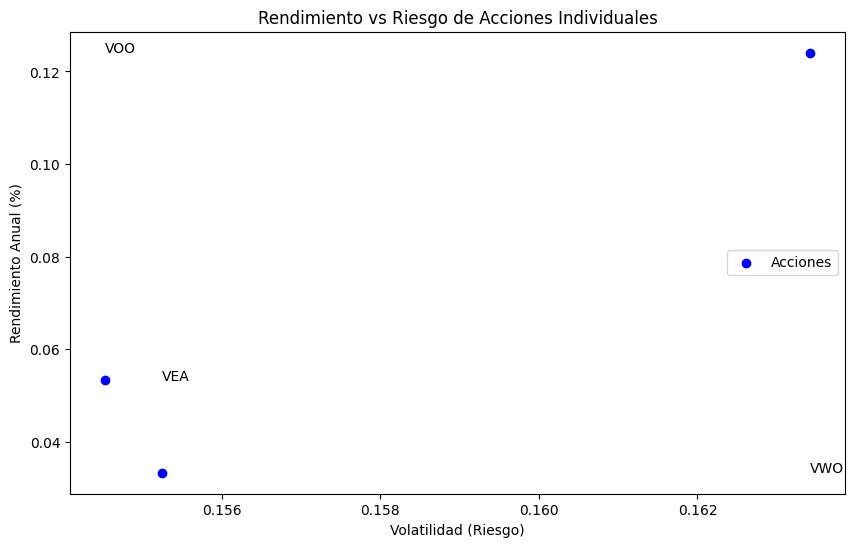

Mapa de correlación


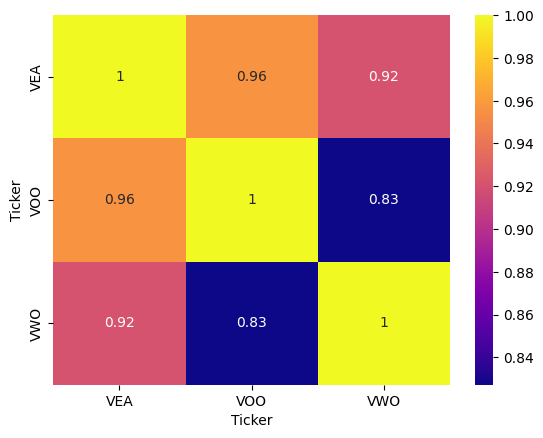

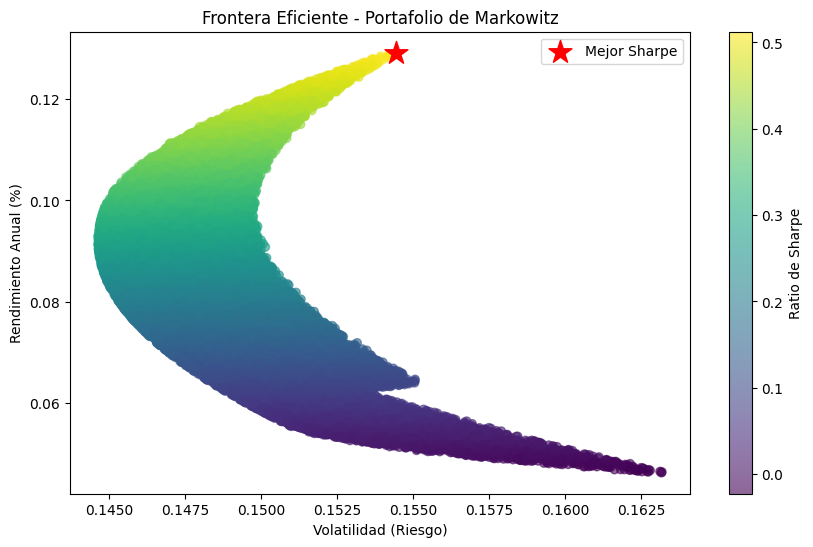

------------------------------------
PORTAFOLIO ÓPTIMO


{'rendimiento': np.float64(0.12913126144723644),
 'volatilidad': np.float64(0.15442742538193283),
 'sharpe_ratio': np.float64(0.5124171516265813),
 'pesos': {'VOO': 0.003, 'VWO': 0.996, 'VEA': 0.001}}

In [ ]:
Prtf_Trad_10_Lib = portafolio_optimo_markowitz(["VOO", "VWO", "VEA"],fecha_inicio = "2015-04-01",fecha_fin="2025-03-31", diversificacion ="Libre")
print("------------------------------------")
print("PORTAFOLIO ÓPTIMO")
Prtf_Trad_10_Lib["portafolio_mejor_sharpe"]

In [ ]:
print("Portafolios Concervadores")
Prtf_Trad_10_Lib["df_portafolios"][(Prtf_Trad_10_Lib["df_portafolios"]["Sharpe"]>=.41) & (Prtf_Trad_10_Lib["df_portafolios"]["Volatilidad"]<=.149)& (Prtf_Trad_10_Lib["df_portafolios"]["VOO"]>=.14)& (Prtf_Trad_10_Lib["df_portafolios"]["VEA"]>=.1)]

Portafolios Concervadores


,Rendimiento,Volatilidad,Sharpe,VOO,VWO,VEA
33,0.111070,0.148525,0.411179,0.148,0.748,0.104
404,0.111017,0.148468,0.410976,0.145,0.748,0.107
534,0.110956,0.148659,0.410039,0.153,0.745,0.103
14992,0.111344,0.148516,0.413044,0.140,0.753,0.107
23585,0.110868,0.148430,0.410079,0.146,0.746,0.108
23817,0.111861,0.148709,0.415988,0.141,0.759,0.100


${\bf \text{*:La gráfica nos muestra que no hay portafolios con un mayor rendimiento significativo}}$

## Portafolios Actuales
Balanceados

<ipython-input-47-c2b2f79072ee>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes



Rendimiento TOTAL en el periodo ( 3623 días):
 Ticker
BTC-USD    347.660873
CHIQ         0.711771
GLD          1.503393
VEA          0.673105
VOO          2.189461
VWO          0.384318
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
BTC-USD    0.804307
CHIQ       0.055686
GLD        0.096926
VEA        0.053257
VOO        0.124040
VWO        0.033329
dtype: float64
Volatilidades anuales (acciones):
 Ticker
VOO        0.154531
VWO        0.163416
CHIQ       0.311690
VEA        0.155251
GLD        0.140575
BTC-USD    0.746478
dtype: float64


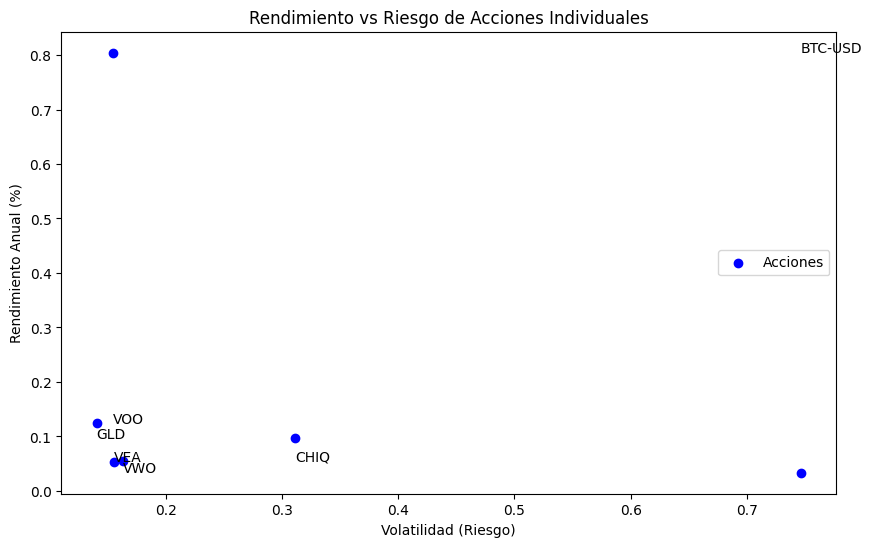

Mapa de correlación


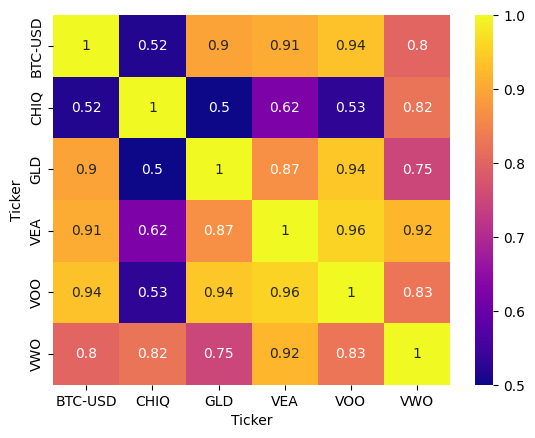

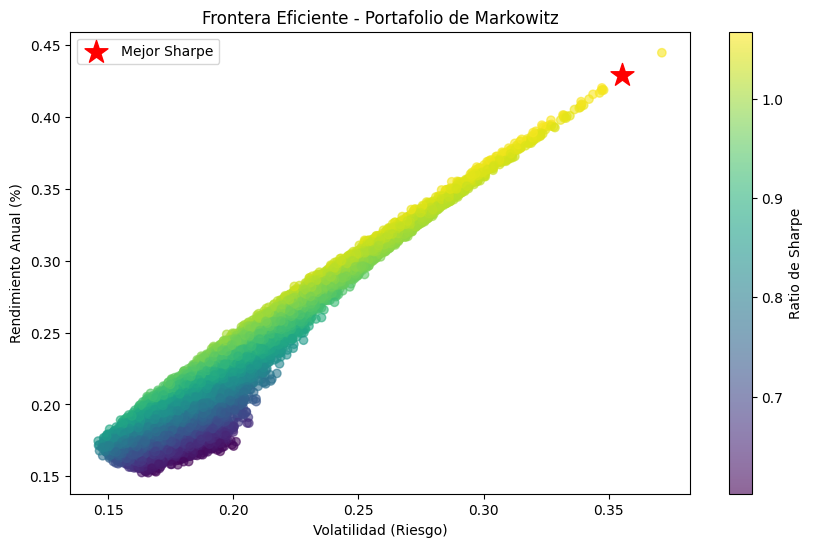

------------------------------------
PORTAFOLIO ÓPTIMO


{'rendimiento': np.float64(0.42925472003518356),
 'volatilidad': np.float64(0.3552801719349169),
 'sharpe_ratio': np.float64(1.0674806814286797),
 'pesos': {'VOO': 0.441,
  'VWO': 0.109,
  'CHIQ': 0.125,
  'VEA': 0.101,
  'GLD': 0.125,
  'BTC-USD': 0.1}}

In [ ]:
Prtf_Act_Bal = portafolio_optimo_markowitz(["VOO", "VWO","CHIQ", "VEA","GLD","BTC-USD"],fecha_inicio = "2015-04-01",fecha_fin="2025-03-31")
print("------------------------------------")
print("PORTAFOLIO ÓPTIMO")
Prtf_Act_Bal["portafolio_mejor_sharpe"]

In [ ]:
print("Portafolios Concervadores")
Prtf_Act_Bal["df_portafolios"][(Prtf_Act_Bal["df_portafolios"]["Sharpe"]>=.91) & (Prtf_Act_Bal["df_portafolios"]["Volatilidad"]<=.164) ]

Portafolios Concervadores


,Rendimiento,Volatilidad,Sharpe,VOO,VWO,CHIQ,VEA,GLD,BTC-USD
3947,0.198128,0.162380,0.912226,0.136,0.103,0.363,0.104,0.164,0.130
5331,0.199195,0.162513,0.918052,0.134,0.109,0.334,0.104,0.212,0.107
8009,0.199777,0.162994,0.918910,0.136,0.101,0.340,0.114,0.198,0.112
16917,0.201762,0.163875,0.926084,0.141,0.102,0.392,0.113,0.138,0.114


${\bf \text{*:La gráfica nos muestra que no hay portafolios con un mayor rendimiento significativo}}$

## Portafolios Actuales
Libres

<ipython-input-47-c2b2f79072ee>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()  # Último precio de cada mes



Rendimiento TOTAL en el periodo ( 3623 días):
 Ticker
BTC-USD    347.660873
CHIQ         0.711771
GLD          1.503393
VEA          0.673105
VOO          2.189461
VWO          0.384318
dtype: float64

Rendimiento ANUALIZADO (equivalente por año):
 Ticker
BTC-USD    0.804307
CHIQ       0.055686
GLD        0.096926
VEA        0.053257
VOO        0.124040
VWO        0.033329
dtype: float64
Volatilidades anuales (acciones):
 Ticker
VOO        0.154531
VWO        0.163416
CHIQ       0.311690
VEA        0.155251
GLD        0.140575
BTC-USD    0.746478
dtype: float64


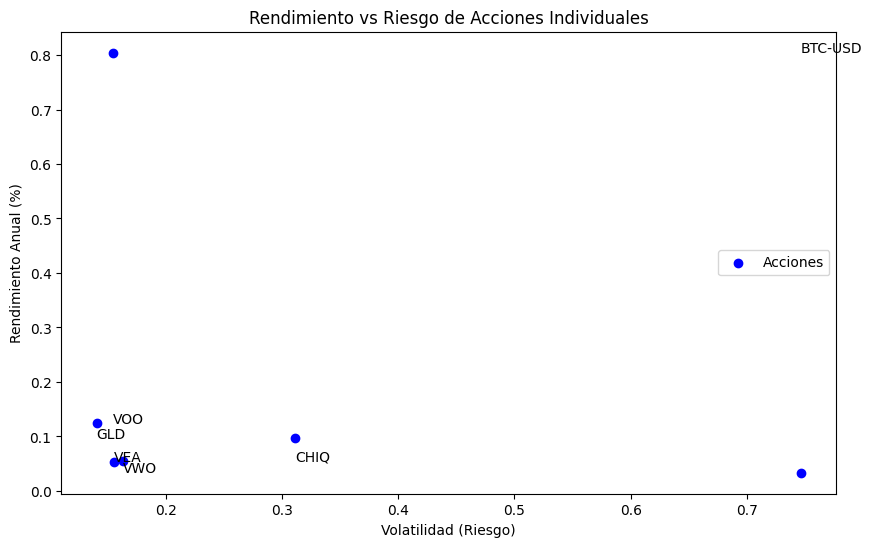

Mapa de correlación


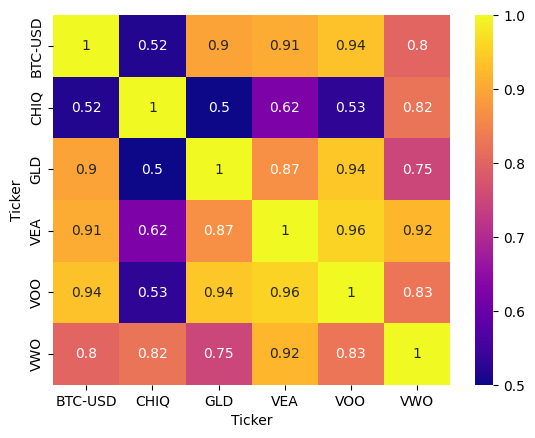

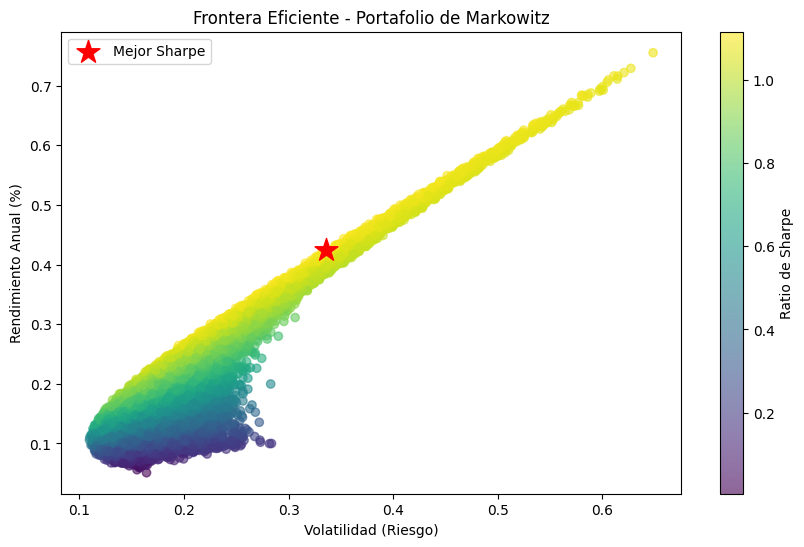

------------------------------------
PORTAFOLIO ÓPTIMO


{'rendimiento': np.float64(0.4251157327240961),
 'volatilidad': np.float64(0.3361028484474156),
 'sharpe_ratio': np.float64(1.1160742447048442),
 'pesos': {'VOO': 0.422,
  'VWO': 0.014,
  'CHIQ': 0.388,
  'VEA': 0.007,
  'GLD': 0.165,
  'BTC-USD': 0.005}}

In [ ]:
Prtf_Act_Lib = portafolio_optimo_markowitz(["VOO", "VWO","CHIQ", "VEA","GLD","BTC-USD"],fecha_inicio = "2015-04-01",fecha_fin="2025-03-31", diversificacion = "Libre")
print("------------------------------------")
print("PORTAFOLIO ÓPTIMO")
Prtf_Act_Lib["portafolio_mejor_sharpe"]

In [ ]:
print("Portafolios Concervadores")
Prtf_Act_Lib["df_portafolios"][(Prtf_Act_Lib["df_portafolios"]["Sharpe"]>=.8) & (Prtf_Act_Lib["df_portafolios"]["Volatilidad"]<=.2)& (Prtf_Act_Lib["df_portafolios"]["Rendimiento"]>=.26) ]

Portafolios Concervadores


,Rendimiento,Volatilidad,Sharpe,VOO,VWO,CHIQ,VEA,GLD,BTC-USD
4534,0.267092,0.199873,1.086149,0.210,0.043,0.398,0.043,0.300,0.006
6716,0.264184,0.199795,1.072017,0.215,0.036,0.542,0.015,0.130,0.061
8677,0.260760,0.199676,1.055509,0.212,0.100,0.530,0.078,0.070,0.010
10941,0.261903,0.198679,1.066560,0.212,0.063,0.513,0.025,0.131,0.056
12836,0.261711,0.197573,1.071560,0.210,0.013,0.653,0.019,0.087,0.019
16917,0.264077,0.194783,1.099052,0.205,0.018,0.495,0.007,0.271,0.004
17208,0.260213,0.197169,1.066154,0.210,0.009,0.515,0.106,0.147,0.013
17693,0.260267,0.199757,1.052613,0.201,0.002,0.285,0.093,0.398,0.022


In [ ]:
print("Portafolios Mayor Rendimiento")
Prtf_Act_Lib["df_portafolios"][  Prtf_Act_Lib["df_portafolios"]["Rendimiento"]>=.72]

Portafolios Mayor Rendimiento


,Rendimiento,Volatilidad,Sharpe,VOO,VWO,CHIQ,VEA,GLD,BTC-USD
2800,0.755202,0.648522,1.087397,0.863,0.012,0.068,0.002,0.051,0.005
6259,0.721938,0.620699,1.082550,0.823,0.001,0.049,0.004,0.061,0.063
9062,0.729002,0.627248,1.082510,0.833,0.021,0.060,0.066,0.015,0.005
